# Table cell detection

The goal of this project is to detect text region in each table cell without using any machine learning or deep learning methods. 

In [1]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ETc

Some predefined constants

In [2]:
MIN_CELL_HEIGHT = 5
MIN_CELL_WIDTH = 5
MIN_TEXT_HEIGHT = 3
MIN_TEXT_WIDTH = 3

Create class Rectangle. Bounding boxes will be declared as rectangle objects

In [3]:
class Rectangle:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

    def height(self):
        return (self.ymax - self.ymin)

    def width(self):
        return (self.xmax - self.xmin)
    
    def area(self):
        return self.height() * self.width()
    
    def valid_cell(self, image_height, image_width):
        return (self.height() > MIN_CELL_HEIGHT)        \
            and (self.width() > MIN_CELL_WIDTH)         \
            and (self.height() < image_height * 0.9)    \
            and (self.width() < image_width * 0.9)
    
    def valid_text(self):
        return self.height() > MIN_TEXT_HEIGHT and self.width() > MIN_TEXT_WIDTH

Draw bounding boxes in image

In [4]:
def draw_rects(image, rects, thickness=2):
    plot_image = image.copy()
    for rect in rects:
        cv2.rectangle(plot_image, (rect.xmin, rect.ymin), (rect.xmax, rect.ymax), (137, 2, 205), thickness)
    return plot_image


Read xml label file and return groundtruth bounding boxes

In [5]:
def read_xml(xml_file):
    tree = ETc.parse(xml_file)
    root = tree.getroot()
    rectsList = []
    for obj in root.findall('object'):
        rectangle = obj.find('bndbox')
        xmin = int(rectangle.find('xmin').text)
        ymin = int(rectangle.find('ymin').text)
        xmax = int(rectangle.find('xmax').text)
        ymax = int(rectangle.find('ymax').text)
        rectsList.append(Rectangle(xmin, ymin, xmax, ymax))
    return rectsList

Get contour of binary image

In [6]:
# Get contours with boundary only
def get_contours(binary_image):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros_like(binary_image, np.uint8)  # create a black image
    image_contour = cv2.drawContours(drawing, contours, -1, (255, 255, 255), 2)
    return image_contour

# Get filled contours
def get_filled_contours(binary_image):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros_like(binary_image, np.uint8)  # create a black image
    image_contour = cv2.drawContours(drawing, contours, -1, (255, 255, 255), -1)
    return image_contour

In [7]:
def get_threshold(gray_image):
    return min(np.median(gray_image) // 2 + 40  , 200)

Extract horizontal and verizontal edges in image

In [8]:
def get_edges(binary_image, scale):
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, max(10, binary_image.shape[0]//scale))) 
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (max(10, binary_image.shape[1]//scale), 1))

    # Use vertical kernel to detect and save the vertical lines in the image
    image_v = cv2.erode(binary_image, kernel_v, iterations=1)
    image_v = cv2.dilate(image_v, kernel_v, iterations=5)

    # Use horizontal kernel to detect and save the horizontal lines in the image
    image_h = cv2.erode(binary_image, kernel_h, iterations=1)
    image_h = cv2.dilate(image_h, kernel_h, iterations=5)

    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    return cv2.add(image_h, image_v)

Get bounding boxes of cells' text

In [9]:
def get_text_in_cell(cell_image, white_text):
    gray = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY)
    # Binarization image
    if white_text == True:
        binary_image = 255*(gray > 200).astype(np.uint8) # chọn chữ trắng (value > 200)
    else:
        binary_image = 255*(gray < 100).astype(np.uint8) # chọn chữ đen (value < 100)

    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    # binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    coords = cv2.findNonZero(binary_image)
    x, y, w, h = cv2.boundingRect(coords)

    return Rectangle(max(x-2,0), max(y-2, 0), x+w+1, y+h+1)



def get_texts_in_image(image, cells, white_text):
    contents = []
    for cell in cells:
        cell_image = image[cell.ymin : cell.ymax, cell.xmin : cell.xmax]
        if cell_image.shape[0] >= MIN_CELL_HEIGHT and cell_image.shape[1] >= MIN_CELL_WIDTH:
            cell_content = get_text_in_cell(cell_image, white_text)
            # convert text's coordinates in cell image to its coordinates in table image
            xmin = cell.xmin + cell_content.xmin
            xmax = cell.xmin + cell_content.xmax
            ymin = cell.ymin + cell_content.ymin
            ymax = cell.ymin + cell_content.ymax

            text_rect = Rectangle(xmin, ymin, xmax, ymax)
            if text_rect.valid_text():
                contents.append(text_rect)

    return contents

Check if 2 bounding boxes are overlapped

In [10]:
def do_overlap(rect1, rect2):     
    # If one rectangle is on left side of other
    if rect1.xmin > rect2.xmax or rect2.xmin > rect1.xmax:
        return False
 
    # If one rectangle is above other
    if rect1.ymin > rect2.ymax or rect2.ymin > rect1.ymax:
        return False
 
    return True

In [11]:
def do_overlap_any(rect1, rects):
    for rect2 in rects:
        if do_overlap(rect1, rect2):
            return True
    return False

Create masks of a binary image

In [12]:
def get_mask(binary_image):
    """
    Parameters:
        - binary_image: a binary image
    Return:
        - mask_1: 
        - mask_2:
    """
    
    def mask_white_background(_binary_image):
        _kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        _mask = cv2.morphologyEx(_binary_image, cv2.MORPH_CLOSE, _kernel)
        return _mask
    
    def mask_white_text(_binary_image):
        _kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        _mask = cv2.dilate(_binary_image, _kernel)
        _mask = get_filled_contours(_mask)
        return _mask

    # Generate mask of the image
    mask_1 = cv2.bitwise_and(mask_white_background(binary_image), binary_image)
    mask_2 = cv2.bitwise_and(mask_white_text(255 - binary_image), 255 - binary_image)

    return mask_1, mask_2


### Detect cells of structured table image

In [13]:
def extract_structured_table(image_mask, image_origin, white_text):
    """ 
    Detect table cells by extracting table edges
    """

    if not white_text:
        mask = 255 - image_mask
    else:
        mask = image_mask.copy()
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(mask, cmap='gray')

    # Extract edges from mask
    image_edges = get_edges(mask, scale=10)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_edges = cv2.dilate(image_edges, kernel, iterations=2)
    image_edges = cv2.bitwise_and(image_edges, mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_edges = cv2.dilate(image_edges, kernel)
    plt.subplot(2, 2, 2)
    plt.imshow(image_edges, cmap='gray')

    mask = np.ones(mask.shape, dtype=np.uint8)
    lines = cv2.HoughLinesP(
            image_edges, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=100, # Min number of votes for valid line
            minLineLength=5, # Min allowed length of line
            maxLineGap=10 # Max allowed gap between line for joining them
            )
    if lines is not None:
        for line in lines:
            # Extracted points nested in the list
            x1,y1,x2,y2=line[0]
            # Draw the lines joing the points
            mask = cv2.line(mask,(x1,y1),(x2,y2),(0, 0, 0),2)
    plt.subplot(2, 2, 3)
    plt.imshow(mask, cmap='gray')

    # Get rectangles created by edges
    cells = []
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if contour.shape == (4, 1, 2):
            x, y, w, h = cv2.boundingRect(contour)
            rect = Rectangle(x, y, x+w, y+h)
            if rect.valid_cell(image_height=image_origin.shape[0], image_width=image_origin.shape[1]):
                cells.append(rect)

    text_boxes = get_texts_in_image(image_origin, cells, white_text)
    image_boxes = draw_rects(image_origin, text_boxes)
    plt.subplot(2, 2, 4)
    plt.imshow(image_boxes)

    return cells, text_boxes



### Detect cells of unstructured table image

In [14]:
# Detect cells of unstructured table which has no edges
def extract_unstructured_table(image_mask, image_origin, white_text):

    def _substract(_image1, _image2):   # _image1 - _image2
        return cv2.bitwise_and(_image1, ~_image2)
    
    if not white_text:
        mask = 255 - image_mask
        k = 15
    else:
        mask = image_mask.copy()
        k = 25
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(mask, cmap='gray')

    # Extract edges from mask
    edges = get_edges(mask, scale=k)
    mask = _substract(mask, edges)
    plt.subplot(2, 2, 2)
    plt.imshow(mask, cmap='gray')

    # Apply dilation to image content
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_content = cv2.dilate(mask, kernel, iterations=3)
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, image_origin.shape[0]*2))
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (image_origin.shape[1]*2, 1))
    image_v = cv2.dilate(image_content, kernel_v, iterations=4)
    image_h =cv2.dilate(image_content, kernel_h, iterations=4)
    dilation = cv2.bitwise_and(image_h, image_v)
    plt.subplot(2, 2, 3)
    plt.imshow(dilation, cmap='gray')

    cells = []

    # Get position (x,y), width and height for every contour and show the contour on image
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rect = Rectangle(x, y, x+w, y+h)
        if rect.valid_cell(image_height=image_origin.shape[0], image_width=image_origin.shape[1]):
            cells.append(rect)
            
    image_boxes = draw_rects(image_origin, cells)
    plt.subplot(2, 2, 4)
    plt.imshow(image_boxes)

    return cells

## Table cell detection pipeline

In [15]:
def extract_table(img_table):
    gray_img = cv2.cvtColor(img_table, cv2.COLOR_BGR2GRAY)
    thresh, img_bin = cv2.threshold(gray_img, get_threshold(gray_img), 255, cv2.THRESH_BINARY)

    mask_1, mask_2 = get_mask(img_bin)
    plt.figure(figsize=(20, 40))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_1, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_2, cmap="gray")

    cells_1, text_boxes_1 = extract_structured_table(mask_1, img_table, white_text=False)
    if len(cells_1) < 4:
        cells_1 = extract_unstructured_table(mask_1, img_table, white_text=True)
        text_boxes_1 = cells_1

    cells_2 = extract_unstructured_table(mask_2, img_table, white_text=True)
    nms_cells_2 = []
    for c in cells_2:
        if not do_overlap_any(c, cells_1):
            nms_cells_2.append(c)

    cells = []
    for c in text_boxes_1 + nms_cells_2:
        if not np.all(img_table[c.ymin:c.ymax, c.xmin:c.xmax] == img_table[c.ymin+1][c.xmin+1]):
            cells.append(c)
    
    img_result = draw_rects(img_table, cells, thickness=1)
    return img_result, cells


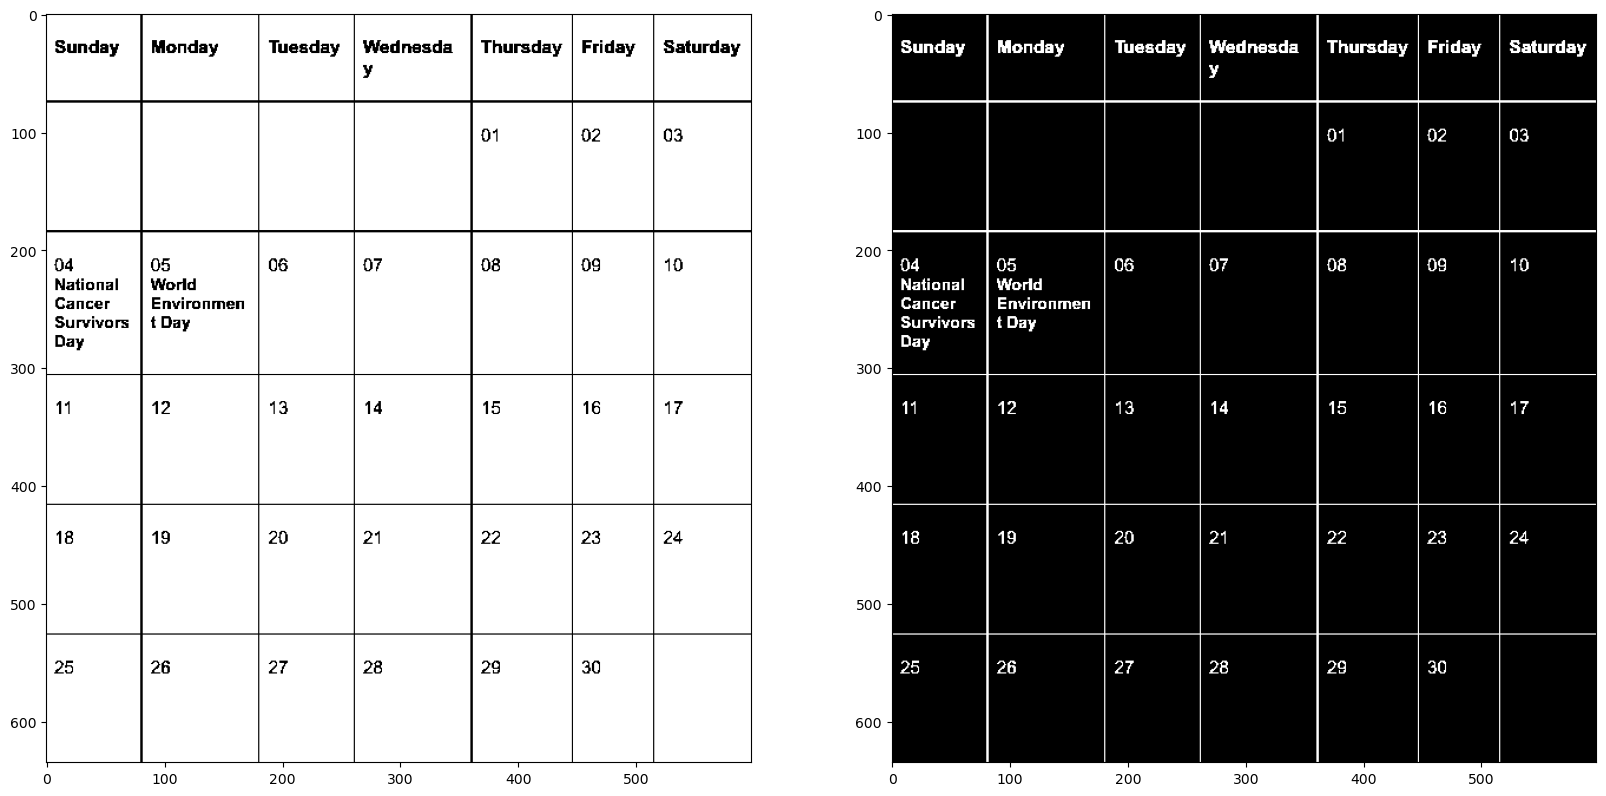

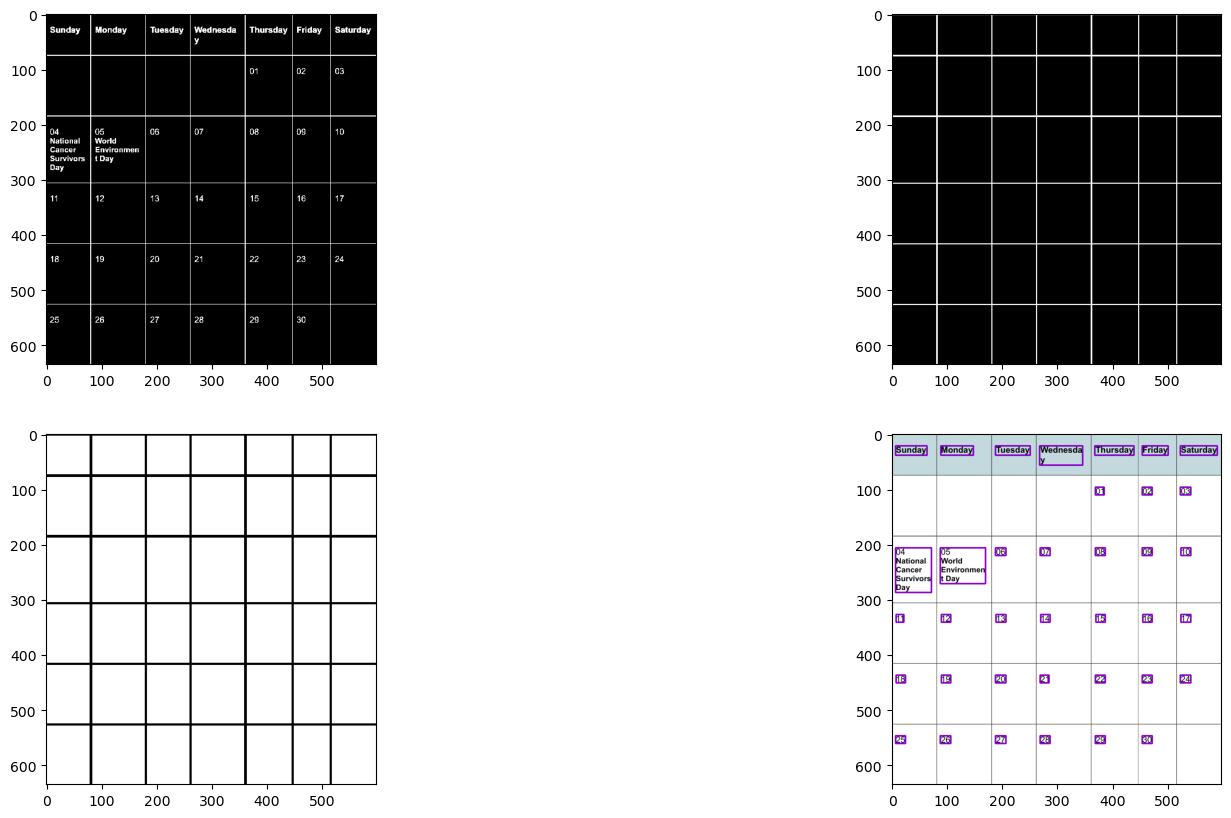

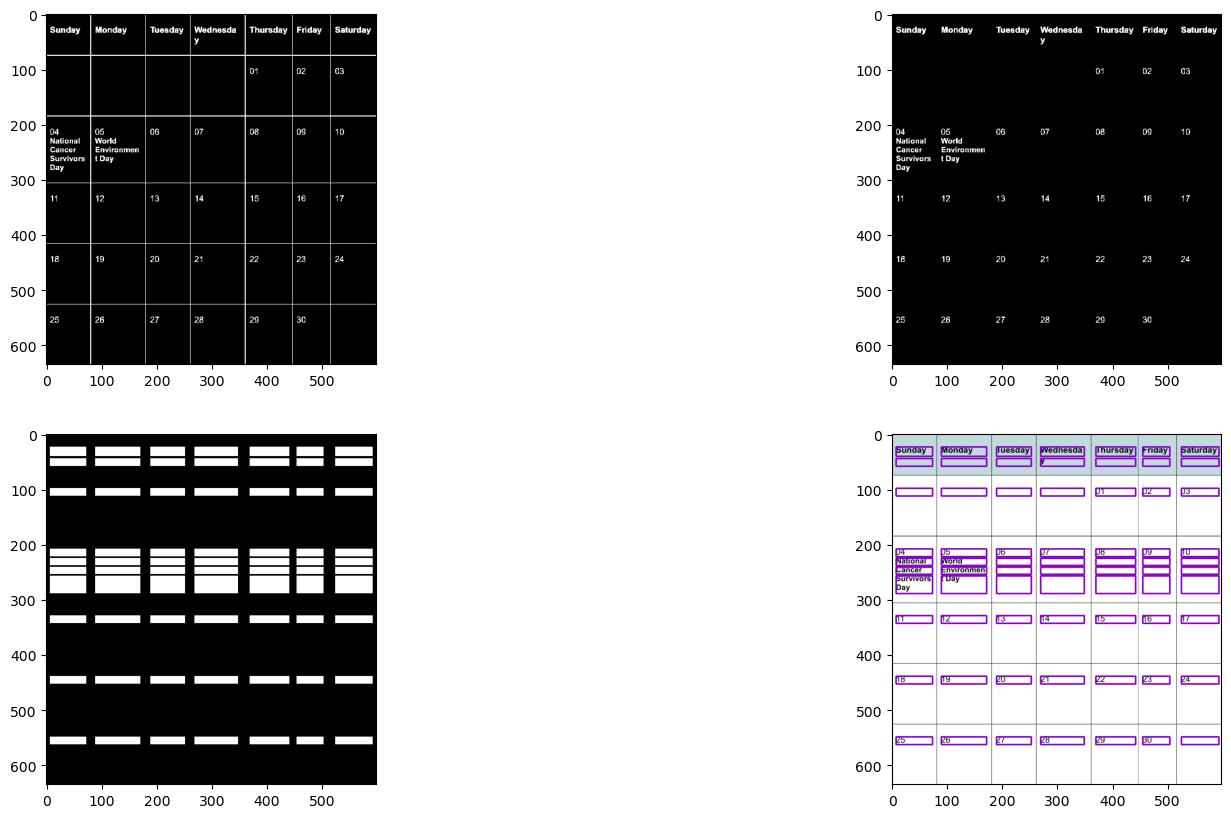

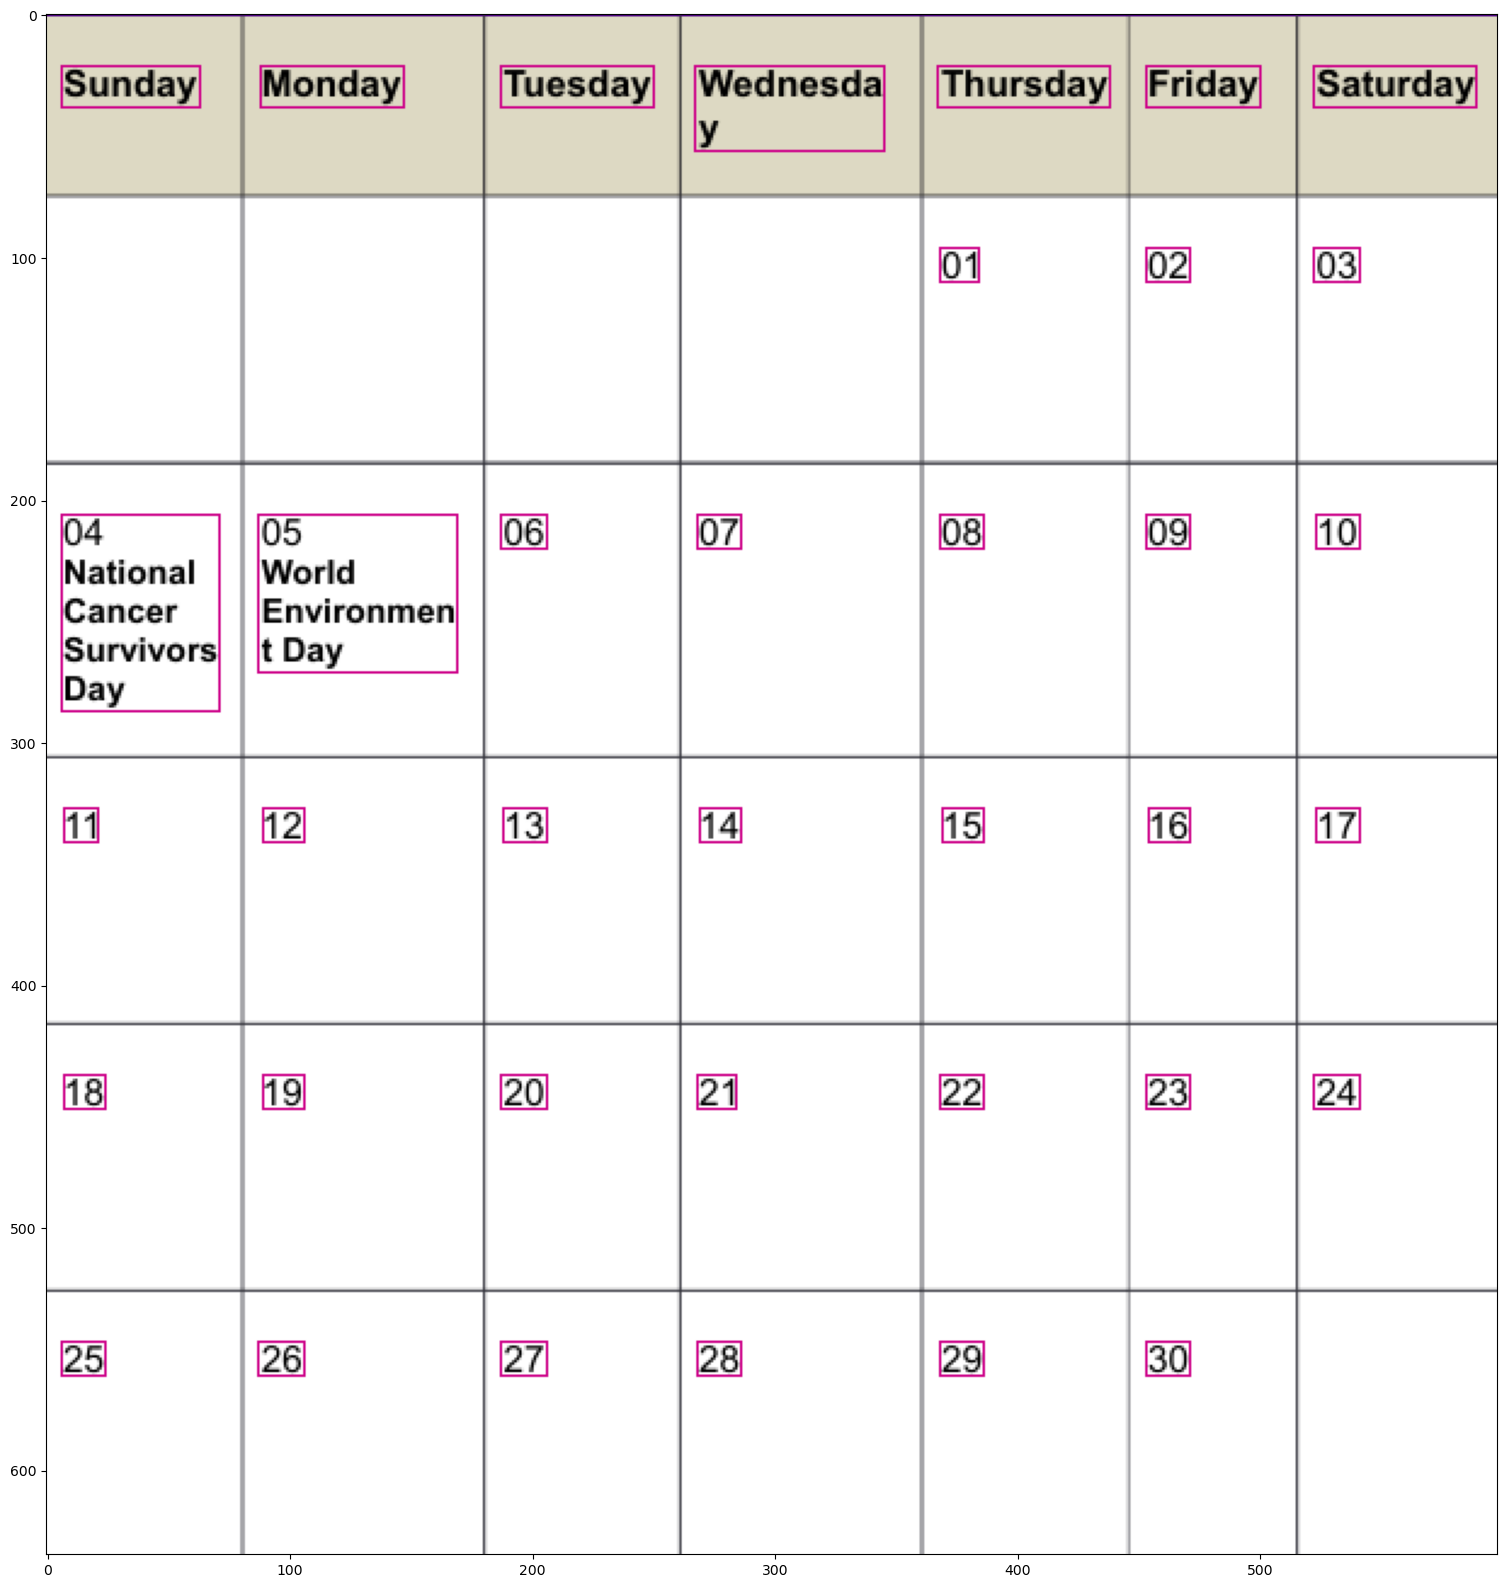

In [22]:
img_table = cv2.imread('images/45.png')
img_table, cells = extract_table(img_table)

plt.figure(figsize=(20, 20))
plt.imshow(img_table[:, :, ::-1])

## Validation


In [18]:
# Check if one prediction bounding box is True positive
def check(pred_rect, gt_rects, iou_threshold):
    gt = gt_rects.copy()
    for gt_rect in gt:
        if do_overlap(pred_rect, gt_rect):
            xcmin = max(pred_rect.xmin, gt_rect.xmin)
            ycmin = max(pred_rect.ymin, gt_rect.ymin)
            xcmax = min(pred_rect.xmax, gt_rect.xmax)
            ycmax = min(pred_rect.ymax, gt_rect.ymax)

            sc = (xcmax - xcmin) * (ycmax - ycmin)
            iou = sc * 1.0 / (pred_rect.area() + gt_rect.area() - sc)

            if iou >= iou_threshold:
                gt.remove(gt_rect)
                return True, gt
    return False, gt

# Validate prediction result of an image
def validate(pred_rects, gt_rects, iou_threshold=0.8):
    num_true_positive = 0
    gts = gt_rects.copy()
    for pred_rect in pred_rects:
        is_true_positive, gts = check(cell[0], cell[1], cell[2], cell[3], gts)
        if is_true_positive:
            num_true_positive = num_true_positive + 1
    
    if len(pred_rects) == 0:
        precision = 0
    else:
        precision = 1.0*num_true_positive/len(pred_rects)

    if len(gt_rects) == 0:
        recall = 0
    else:
        recall = 1.0*num_true_positive/len(gt_rects)

    return {
        "recall": recall,
        "precision": precision,
    }